# Description

#### Ethereum (ETH) is a cryptocurrency . Users are able to generate ETH through the process of mining. Ethereum has a current supply of 118,779,130.1865. The last known price of Ethereum is 3,909.54196658 USD .It is currently trading on 4548 active market(s) with dollar 21,642,412,380.90 traded over the last 24 hours. More information can be found at https://www.ethereum.org/.

In [1]:
## Importing the Packages
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline


In [2]:
# Importing the data
df = pd.read_csv("ETH-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-20,129.384369,129.756302,126.985352,129.066055,129.066055,8.173594e+09
1,2019-12-21,129.095963,129.147659,127.612091,128.130951,128.130951,7.449065e+09
2,2019-12-22,128.098129,133.160034,127.928490,132.372513,132.372513,9.121058e+09
3,2019-12-23,132.306992,134.731750,127.416718,128.614090,128.614090,9.622498e+09
4,2019-12-24,128.629257,131.672287,127.308769,129.063889,129.063889,7.961820e+09


In [3]:
df.shape

(732, 7)

In [4]:
df.dropna(inplace=True)
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-20,129.384369,129.756302,126.985352,129.066055,129.066055,8.173594e+09
2019-12-21,129.095963,129.147659,127.612091,128.130951,128.130951,7.449065e+09
2019-12-22,128.098129,133.160034,127.928490,132.372513,132.372513,9.121058e+09
2019-12-23,132.306992,134.731750,127.416718,128.614090,128.614090,9.622498e+09
2019-12-24,128.629257,131.672287,127.308769,129.063889,129.063889,7.961820e+09


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-16,4020.415039,4110.368652,3956.057129,3962.469727,3962.469727,1.982553e+10
2021-12-17,3959.012451,3992.792480,3711.424561,3879.486572,3879.486572,2.314354e+10
2021-12-18,3880.291504,3993.829834,3774.614990,3960.860107,3960.860107,1.953090e+10
2021-12-19,3960.872314,4018.658447,3894.398682,3922.592529,3922.592529,1.616779e+10
2021-12-20,3912.781738,3978.591797,3772.242920,3808.326416,3808.326416,1.842678e+10


In [7]:
start_date = "2019-12-20"
mid_1 = "2020-12-20"
end_date = "2021-12-20"


<AxesSubplot:xlabel='Date'>

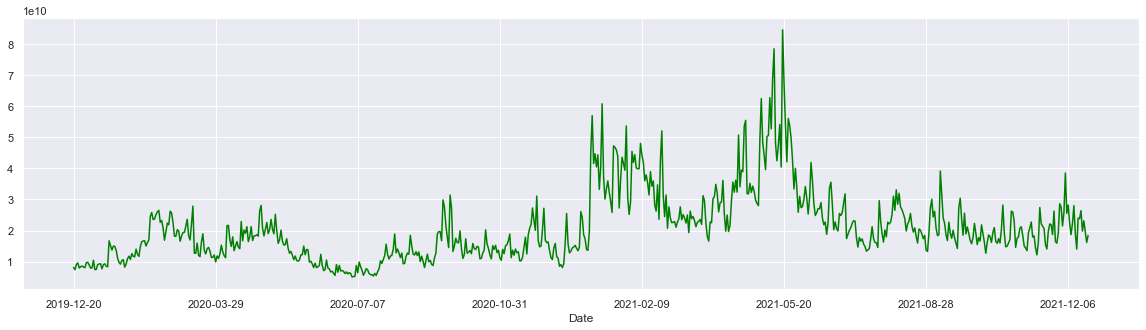

In [8]:
df["Volume"].plot(color = "green",figsize = (20,5))

<AxesSubplot:xlabel='Date'>

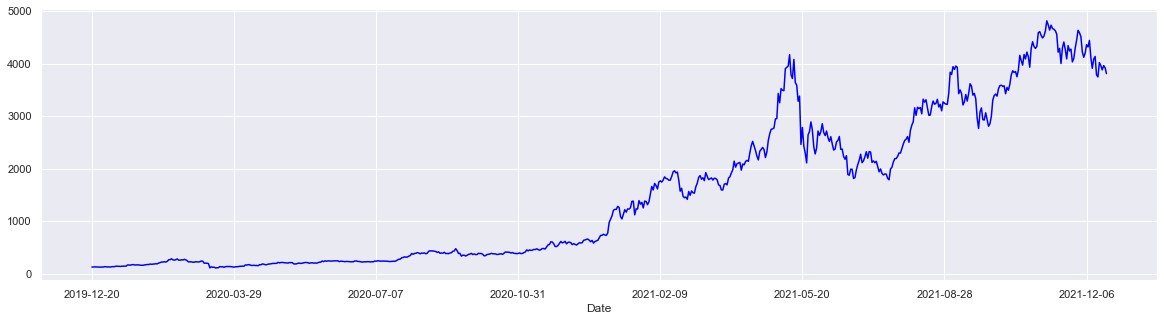

In [9]:
df["Close"].plot(color = "blue",figsize = (20,5))

## Closing Prices


### 1. AD Fuller Test for checking Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(x):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(x, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df['Close'])



Results of Dickey-Fuller Test:
Test Statistic                  -0.214627
p-value                          0.936756
#Lags Used                      17.000000
Number of Observations Used    697.000000
Critical Value (1%)             -3.439767
Critical Value (5%)             -2.865696
Critical Value (10%)            -2.568983
dtype: float64


In [11]:
series = df['Close'].values
result = adfuller(series, autolag='AIC')
print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Stationary")

ADF Statistic: -0.214627
p-value: 0.936756
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Reject Ho - Time Series is Stationary


#### Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

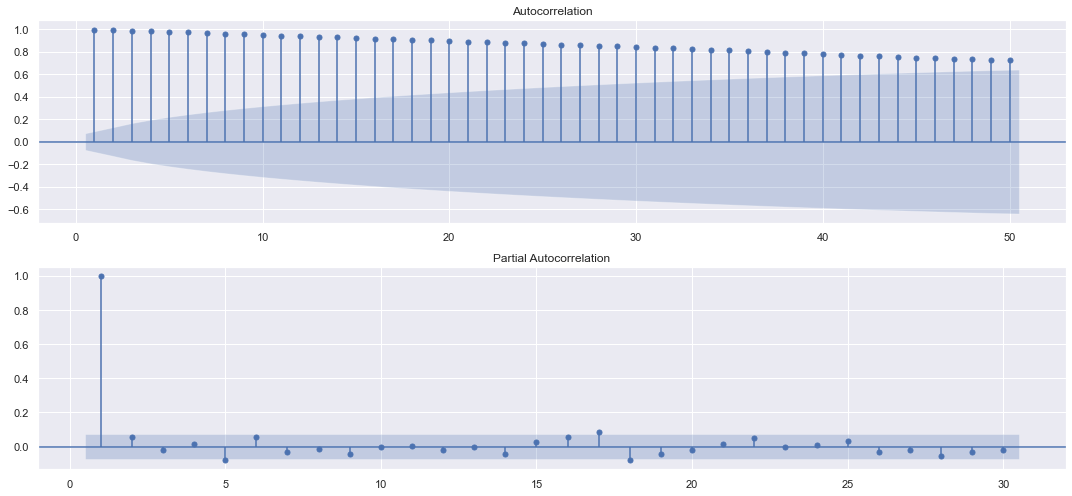

In [12]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Close[13:].values.squeeze(), lags=50, ax=ax,zero=False)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Close[13:].values.squeeze(), lags=30,zero=False
                          , ax=ax)
plt.tight_layout()
plt.show()

## Using ARIMA

In [13]:
#Using only Close
model_auto_pred_pr = auto_arima(df.Close[start_date:mid_1], exogenous = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']][start_date:mid_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[mid_1:end_date]),exogenous = df[['Open', 'High', 'Low','Adj Close', 'Volume']][mid_1:end_date]),
                               index = df[mid_1:end_date].index)



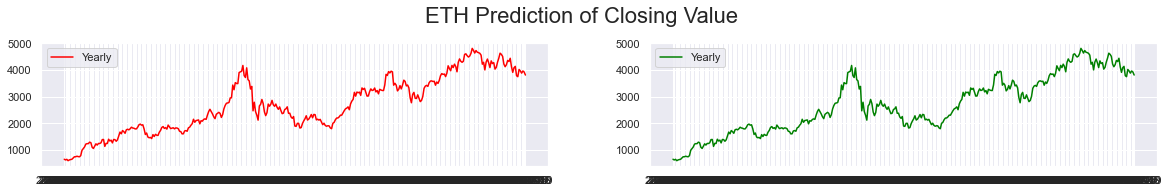

In [14]:
fig = plt.figure(figsize=[20, 5])
plt.suptitle("ETH Prediction of Closing Value", fontsize=22)

plt.subplot(221)
plt.plot(df_auto_pred_pr[mid_1:end_date], '-',color = "red",label = "Yearly")
plt.legend()

plt.subplot(222)
plt.plot(df.Close[mid_1:end_date], '-', color = "green",label = "Yearly")
plt.legend()

### This is OK

### Volatility trend for each time period

<AxesSubplot:xlabel='Date'>

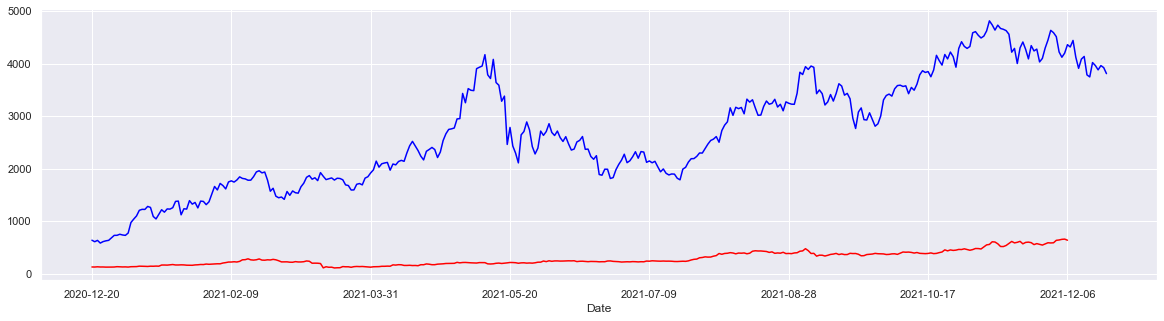

In [15]:
df.Close[start_date:mid_1].plot(figsize = (20,5),color = "red")
df.Close[mid_1:end_date].plot(color = "blue")

## Using Facebook Prophet

pip install pystan==2.19.1.1

pip install prophet

!pip install fbprophet

In [16]:
df_2 = pd.read_csv("ETH-USD.csv")
df_2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-20,129.384369,129.756302,126.985352,129.066055,129.066055,8.173594e+09
1,2019-12-21,129.095963,129.147659,127.612091,128.130951,128.130951,7.449065e+09
2,2019-12-22,128.098129,133.160034,127.928490,132.372513,132.372513,9.121058e+09
3,2019-12-23,132.306992,134.731750,127.416718,128.614090,128.614090,9.622498e+09
4,2019-12-24,128.629257,131.672287,127.308769,129.063889,129.063889,7.961820e+09


In [17]:
df_2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,715.000000,715.000000,715.000000,715.000000,715.000000,7.150000e+02
mean,1503.094851,1557.939799,1442.865644,1507.658507,1507.658507,2.080548e+10
std,1420.090809,1467.943502,1365.295440,1420.882440,1420.882440,1.127060e+10
min,110.406784,116.021622,95.184303,110.605873,110.605873,5.109033e+09
25%,239.064079,243.665497,233.749199,239.266854,239.266854,1.316100e+10
50%,659.185059,711.393555,646.616211,682.642334,682.642334,1.837147e+10
75%,2532.247071,2653.412964,2402.139770,2537.050537,2537.050537,2.549429e+10
max,4810.071289,4891.704590,4718.039063,4812.087402,4812.087402,8.448291e+10


In [18]:
data = df_2[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset
data.head()

,ds,y
0,2019-12-20,129.066055
1,2019-12-21,128.130951
2,2019-12-22,132.372513
3,2019-12-23,128.614090
4,2019-12-24,129.063889


In [19]:
data.dropna(inplace=True)

In [20]:
from fbprophet import Prophet
model = Prophet(daily_seasonality = True) 
model.fit(data)

Initial log joint probability = -11.003


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1705.73    0.00383743       429.325      0.4931      0.4931      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       1721.03   0.000239743       228.055   1.317e-06       0.001      237  LS failed, Hessian reset 
     199       1727.01   0.000426247       90.4564           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1732.93     0.0791965       208.615           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       1733.13   0.000566912        438.91   2.422e-06       0.001      464  LS failed, Hessian reset 
     399        1737.4   0.000106272       77.4836      0.1565      0.1565      583   
    Iter      log prob        ||dx||      ||grad||       alpha

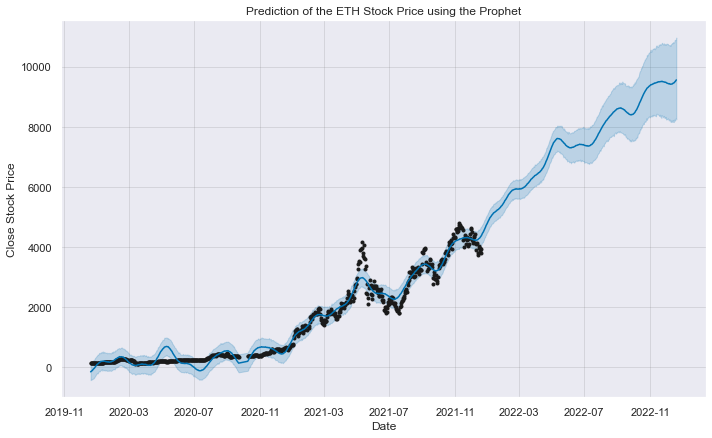

In [21]:
future = model.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = model.predict(future)
model.plot(prediction)
plt.title("Prediction of the ETH Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

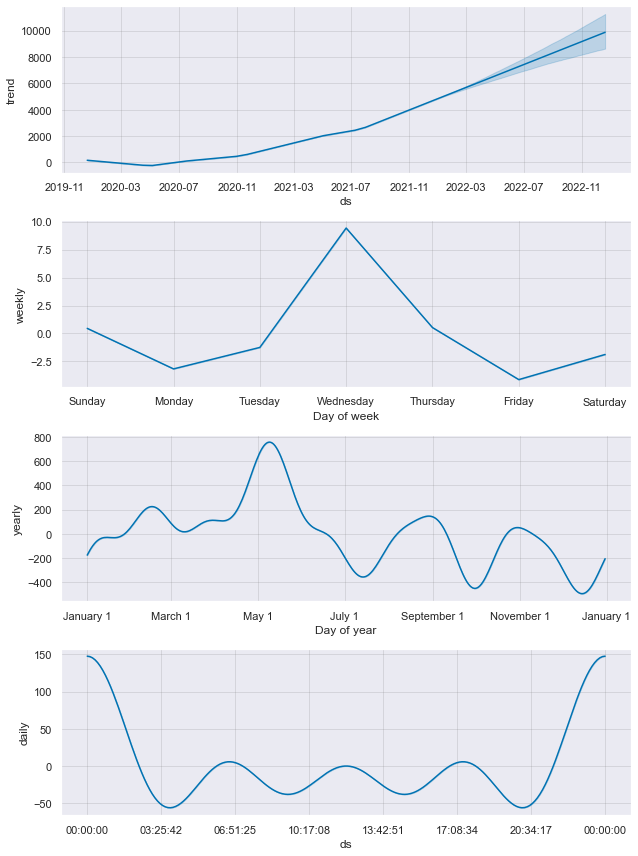

In [22]:
model.plot_components(prediction)
plt.show()